In [1]:
import pandas as pd
import datetime as dt
import time
import numpy as np
import sys

In [2]:
covid = pd.read_excel('data/acaps_data.xlsx', index_col=0, converters={'Date': str})
covid.head()
covid.columns

Index(['COUNTRY', 'ISO', 'ADMIN_LEVEL_NAME', 'PCODE', 'REGION', 'LOG_TYPE',
       'CATEGORY', 'MEASURE', 'TARGETED_POP_GROUP', 'COMMENTS',
       'NON_COMPLIANCE', 'DATE_IMPLEMENTED', 'SOURCE', 'SOURCE_TYPE', 'LINK',
       'ENTRY_DATE', 'Alternative source'],
      dtype='object')

#### data cleaning

In [3]:
covid['DATE_IMPLEMENTED'] = pd.to_datetime(covid['DATE_IMPLEMENTED'], infer_datetime_format=True)
covid['DATE_IMPLEMENTED'] = covid['DATE_IMPLEMENTED'].dt.date

#inaccurate date of decl of emergency in US, removing
covid = covid.drop([covid.index[4292] , covid.index[4298]])

### Loading JHU time series dataset

In [4]:
#wd = os.getcwd()
jhu_time = pd.read_csv("https://raw.githubusercontent.com/datasets/covid-19/master/data/time-series-19-covid-combined.csv")
jhu_time['Date'] = pd.to_datetime(jhu_time['Date'], infer_datetime_format=True)
jhu_time['Date'] = jhu_time['Date'].dt.date

sub = jhu_time[jhu_time['Confirmed'] > 0.0]
first_case = sub.groupby('Country/Region')['Date'].min().reset_index().sort_values(by=['Country/Region'])
first_case.rename(columns={'Country/Region': 'COUNTRY'}, inplace=True)
first_case

,COUNTRY,Date
0,Afghanistan,2020-02-24
1,Albania,2020-03-09
2,Algeria,2020-02-25
3,Andorra,2020-03-02
4,Angola,2020-03-20
...,...,...
182,West Bank and Gaza,2020-03-05
183,Western Sahara,2020-04-05
184,Yemen,2020-04-10
185,Zambia,2020-03-18


In [5]:
stats = jhu_time.groupby("Country/Region")[['Confirmed', 'Recovered', 'Deaths']].max()
stats[stats.index == 'US']


,Confirmed,Recovered,Deaths
Country/Region,,,
US,1158040.0,180152.0,67682.0


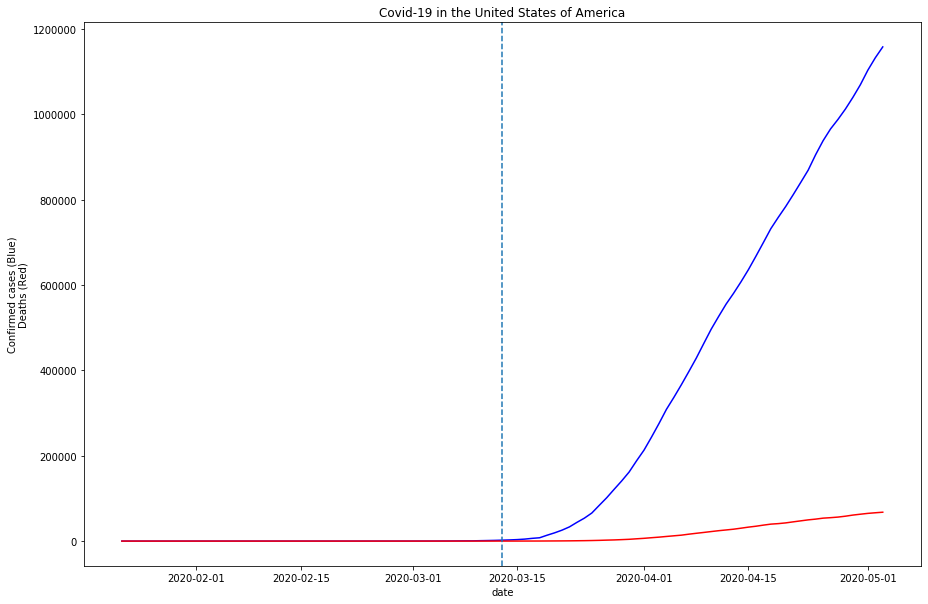

In [6]:
us = jhu_time[jhu_time['Country/Region'] == 'US']
us_soe  = dt.datetime(2020, 3, 13)

import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
%matplotlib inline

fig, ax = plt.subplots(figsize=(15,10))
g = sns.lineplot(x=us['Date'], y=us['Confirmed'],  color='blue', ax=ax)
g = sns.lineplot(x=us['Date'], y=us['Deaths'],  color='red', ax=ax)
g.set(xlabel='date', ylabel='Confirmed cases (Blue)\nDeaths (Red)', title='Covid-19 in the United States of America')
#ax.set_yscale('log')
ax.axvline(us_soe, ls='--')
plt.show()


#### cleaning

In [7]:
renaming = {'Czech republic': 'Czech Republic', 'Czechia': 'Czech Republic', 'Myanmar': 'Burma', 
          'West Bank and Gaza': 'Palestine', 'Brunei Darussalam': 'Brunei', 'Korea Republic of' : 'South Korea',
          'Korea, Rep.' : 'South Korea', 'Korea, South' : 'South Korea',  'Cote d\'Ivoire': 'Côte d\'Ivoire', 
            'North Macedonia Republic Of': 'North Macedonia', 'Congo': 'Congo (Brazzaville)', 
            'Congo DR': 'Congo (Kinshasa)', 'Congo, Dem. Rep.':'Congo (Kinshasa)',
          "Congo, Rep.":'Congo (Brazzaville)',  'Russian Federation': 'Russia', 'Egypt, Arab Rep.': 'Egypt',
          'Micronesia, Fed. Sts.':'Micronesia','Moldova Republic of': 'Moldova', 'Moldova Republic Of': 'Moldova', 
            'Lao PDR': 'Laos', 'Viet Nam': 'Vietnam', 'US': 'United States of America', "Bahamas, The": "Bahamas",
            "Gambia, The" : "Gambia", 'Iran, Islamic Rep.': "Iran", "Kyrgyzstan": "Kyrgyz Republic", 
            'St. Lucia' : "Saint Lucia", "Slovakia" : "Slovak Republic", 'Syrian Arab Republic' : "Syria",
           'United States' : 'United States of America', 
            'St. Vincent and the Grenadines' : 'Saint Vincent and the Grenadines', 'Venezuela, RB': 'Venezuela',
            'Yemen, Rep.' : 'Yemen'}

covid['COUNTRY'] = covid['COUNTRY'].replace(renaming)
first_case['COUNTRY'] = first_case['COUNTRY'].replace(renaming)



countries = covid.groupby('COUNTRY').size().reset_index(name='# measures')
countries

#ACAPA ----------------- JHU
#Tonga ---- n/a
# Samoa -------- n/a
# Vanuatu -------- n/a
# Solomon Islands -- n/a
#Palau -> has 0 cases -> what do?
#Marshall Islands 
#Nauru ? - usa
#Hong Kong?
#Micronesia -> No cases?
#Turkmenistan -> no cases
#Lesotho -> no cases 
#Comoros -> no cases
#Kiribati -> ?
# Tajikistan -> no cases
#Tuvalu ?
#Korea DPR -> No cases

,COUNTRY,# measures
0,Afghanistan,49
1,Albania,22
2,Algeria,18
3,Angola,49
4,Antigua and Barbuda,8
...,...,...
188,Venezuela,15
189,Vietnam,5
190,Yemen,22
191,Zambia,20


below is a check that all countries are included:

In [8]:
len(countries)
countries

,COUNTRY,# measures
0,Afghanistan,49
1,Albania,22
2,Algeria,18
3,Angola,49
4,Antigua and Barbuda,8
...,...,...
188,Venezuela,15
189,Vietnam,5
190,Yemen,22
191,Zambia,20


Merging first_case onto countries df

In [9]:
countries = pd.merge(countries, first_case, on='COUNTRY', how='outer')

Creating Curfew dummy column

In [10]:
subset = covid[covid.MEASURE == "Curfews"]
curfew = subset.groupby('COUNTRY').size().reset_index(name='count')
countries['Curfew'] = np.where(countries['COUNTRY'].isin(curfew['COUNTRY']), 1, 0)
countries

,COUNTRY,# measures,Date,Curfew
0,Afghanistan,49.0,2020-02-24,0
1,Albania,22.0,2020-03-09,1
2,Algeria,18.0,2020-02-25,1
3,Angola,49.0,2020-03-20,0
4,Antigua and Barbuda,8.0,2020-03-13,0
...,...,...,...,...
196,Kosovo,NaN,2020-03-26,0
197,MS Zaandam,NaN,2020-03-28,0
198,Monaco,NaN,2020-02-29,0
199,Taiwan*,NaN,2020-01-22,0


Getting the date of the first declaration of national emergency. The first declaration measure seems to be a good indicator of
responsiveness, but may need to be explored a bit further.

In [11]:
emergency_countries = covid[covid.MEASURE == "State of emergency declared"]
emergency_date = emergency_countries.groupby('COUNTRY')['DATE_IMPLEMENTED'].min().reset_index()
countries = pd.merge(countries, emergency_date, on='COUNTRY', how='left')
countries.rename(columns={"DATE_IMPLEMENTED": "Emergency Date", 'COUNTRY':'Country', 'Date':'First Case'}, inplace=True)


Cleaning/Preparing World Bank data and merging on larger data frame 

In [12]:
pop_old = pd.read_excel('data/popabove65.xls', sheet_name='Data', header=3, usecols = ["Country Name", "2018"]) 

hbeds = pd.read_excel('data/hospbeds.xls', sheet_name='Data', header=3) 
#hbeds['Country Name'] = hbeds['Country Name'].replace(renaming)

yrs = hbeds[hbeds.columns[4:]]
yrs = yrs.ffill(axis=1)['2019']
wb_data = pd.concat([hbeds['Country Name'], yrs, pop_old['2018']], axis=1)
wb_data.rename(columns={'2019': 'Hospital Beds/1k', 'Country Name': 'Country', '2018': 'Share Pop 65+'}, inplace=True)

countries = pd.merge(countries, wb_data, how='inner', on='Country')
countries

,Country,# measures,First Case,Curfew,Emergency Date,Hospital Beds/1k,Share Pop 65+
0,Afghanistan,49.0,2020-02-24,0,2020-02-24,0.5,2.584927
1,Albania,22.0,2020-03-09,1,NaN,2.9,13.744736
2,Algeria,18.0,2020-02-25,1,NaN,1.9,6.362497
3,Angola,49.0,2020-03-20,0,2020-03-27,0.8,2.216374
4,Antigua and Barbuda,8.0,2020-03-13,0,NaN,3.8,8.799826
...,...,...,...,...,...,...,...
168,Zambia,20.0,2020-03-18,0,NaN,2.0,2.099678
169,Zimbabwe,11.0,2020-03-20,0,NaN,1.7,2.939524
170,Andorra,NaN,2020-03-02,0,NaN,2.5,NaN
171,Kosovo,NaN,2020-03-26,0,NaN,NaN,NaN


In [13]:
countries[countries['Emergency Date'].notnull()]
countries[countries['Country'] == 'United States of America']

,Country,# measures,First Case,Curfew,Emergency Date,Hospital Beds/1k,Share Pop 65+
